In [1]:
import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import sys
import torch
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import yaml
from scipy.fft import rfft

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lab_scripts.constellation_diagram import RingShapedConstellation, get_constellation, QPSK_Constellation
from modules.models import TCN_channel, TCN, memory_polynomial_channel, ABC_time_model
from modules.utils import *

/Users/dylanjones/opt/miniconda3/envs/mldrivenpeled2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_name = "channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-9.2MHz_2.775.V_0.129A_60ma_scale2_dynamic_power_0.5-3.zarr"
# file_name = "channel_3e5-10.8MHz_2.834V_0.135A_80mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-13MHz_2.934V_0.121A_121mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-20MHz_2.739V_0.125A_47mA_scale2_dynamic_power_0.5-3_v2.zarr"
# file_name = "channel_3e5-15.2MHz_2.734V_0.126A_47mA_scale2_dynamic_power_0.5-3_v2.zarr"

file_path = rf"../data/channel_measurements/zarr_files/{file_name}"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for M chip Macs
else:
    DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)

ofdm_info = extract_zarr_data(file_path, DEVICE)
sent_frames_time = ofdm_info.sent_frames_time
received_frames_time = ofdm_info.received_frames_time
dataset = ChannelData(sent_frames_time, received_frames_time, ofdm_info.FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))


val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
TRAIN_DATASET, VAL_DATASET, TEST_DATASET = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)
print("Train Size", train_size)

DEVICE mps


/Users/dylanjones/Desktop/mldrivenpeled/modules/utils.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!
Train Size 5015


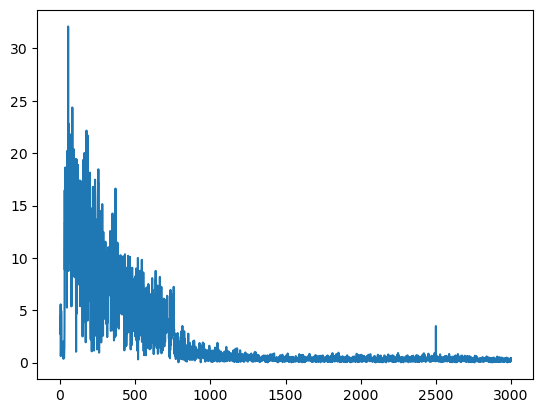

In [3]:
t = torch.fft.fft(received_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

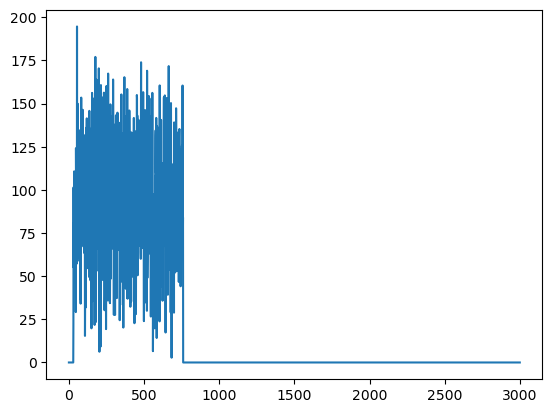

In [4]:
t = torch.fft.fft(sent_frames_time[0, ofdm_info.CP_LENGTH:].cpu()).abs()
plt.plot(t[:len(t)//2])

In [5]:

def train(model, optimizer, loss_fn, loop, log_to_wandb=True):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        if model.learn_noise:
            noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
        else:
            y_pred = model(x)
        # calculate residual
        r = y - y_pred
        if model.learn_noise:
            if model.gaussian:
                loss = loss_fn(r, y_pred_std)
            else:
                loss = loss_fn(r, y_pred_std, y_pred_nu)
        else:
            loss = loss_fn(y, y_pred)

        mse_loss = F.mse_loss(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        if log_to_wandb:
            wandb.log({"nnl_train_loss": loss.item()})
            wandb.log({"mse_train_loss": mse_loss.item()})
            wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
    loop.close()

def val(model,
        loss_fn,
        val_loader,
        ofdm_info: OFDM_channel,
        memory_polynomial=None,
        log_to_wandb=True):
    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    std_preds = []
    nu_preds = []
    true_ys = []
    noisy_ys = []
    val_mse_loss = 0
    rrmse_pct_loss = 0.0
    mse_mem_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            if model.learn_noise:
                noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
                std_preds.append(y_pred_std)
                nu_preds.append(y_pred_nu)
                noisy_ys.append(noisy_y_pred)
            else:
                y_pred = model(x)
            y_preds.append(y_pred)
            true_ys.append(y)

            if model.learn_noise:
                if model.gaussian:
                    loss = loss_fn(y - y_pred, y_pred_std) # Use mean for validation
                else:
                    loss = loss_fn(y - y_pred, y_pred_std, y_pred_nu) # Use mean for validation
            else:
                loss = loss_fn(y, y_pred)
            mse_loss = F.mse_loss(y, y_pred)

            rrmse_pct_loss += calculate_rrmse_pct_loss(y, y_pred)
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            if memory_polynomial:
                y_pred_mp = memory_polynomial(x)
                mse_mem_loss += calculate_rrmse_pct_loss(y.to(y_pred_mp.device), y_pred_mp)
            batch_count += 1


    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)
    avg_val_mem_loss = (mse_mem_loss / batch_count)
    avg_nrmse_pct_loss = (rrmse_pct_loss / batch_count)

    y_preds = torch.vstack(y_preds)
    true_ys = torch.vstack(true_ys)
    residuals = true_ys - y_preds
    compute_billings_corrs(residuals, y_preds, lag_max=30, log_wandb=True, prefix="val_billings_corrs")


    if model.learn_noise:
        std_preds = torch.vstack(std_preds)
        nu_preds = torch.vstack(nu_preds)
        noisy_ys = torch.vstack(noisy_ys)

        avg_std = std_preds.mean().item()
        avg_nu = nu_preds.mean().item()
        if log_to_wandb:
            wandb.log({
                'avg_val_pred_std': avg_std,
            })
            if not model.gaussian:
                wandb.log({
                    'avg_val_pred_nu': avg_nu,
                })


    if log_to_wandb:
        # Log both scalar and histogram
        wandb.log({
            'val_nll_loss': avg_val_loss,
            "avg_val_mse_loss": avg_val_mse_loss,
            "avg_nrmse_pct_loss": avg_nrmse_pct_loss
        })
        if memory_polynomial:
            wandb.log({
                'val_mem_poly_nrmse_pct_loss': avg_val_mem_loss
            })
        if model.learn_noise:
            log_snr_plots(y_preds, noisy_ys, ofdm_info)

    return avg_val_loss, avg_nrmse_pct_loss

In [6]:
memory_polynomial = memory_polynomial_channel(weights=None, memory_linear=10, memory_nonlinear=10, nonlinearity_order=2, device=DEVICE)
train_indices = TRAIN_DATASET.indices
X_train = dataset.sent[train_indices].to(DEVICE)
y_train = dataset.received[train_indices].to(DEVICE)
_, _, _ = memory_polynomial.fit(X_train, y_train)

MPS not supported. . . switching to CPU


In [7]:
memory_polynomial.calculate_err(X_train, y_train, plot=True)

del X_train, y_train

--------------------------------------------------
Rank  | Term String          | ERR (%)        
--------------------------------------------------
1     | x[0]                 | 47.567338%
2     | x[-1]                | 20.103796%
3     | x[-2]                | 10.763846%
4     | x[-3]                | 4.127679%
5     | x[-4]                | 2.428556%
6     | x[0]^2               | 1.961511%
7     | x[-5]                | 1.578190%
8     | x[-6]                | 1.141948%
9     | x[-1]^2              | 0.948946%
10    | x[-7]                | 0.782512%
11    | x[-4]^2              | 0.575480%
12    | x[-5]^2              | 0.554938%
13    | x[-8]                | 0.484166%
14    | x[-6]^2              | 0.389958%
15    | x[-9]                | 0.326062%
16    | x[-3]^2              | 0.246452%
17    | x[-10]               | 0.235005%
18    | x[-7]^2              | 0.218162%
19    | x[-8]^2              | 0.146406%
20    | x[-9]^2              | 0.104387%
21    | x[-2]^2             

In [8]:
def students_t_loss(difference, y_pred_std, y_pred_nu):
    nu = y_pred_nu
    z_resid = (difference) / (y_pred_std)
    term1 = -1 * torch.lgamma((nu + 1) / 2) + 0.5 * torch.log(torch.pi * nu) + torch.lgamma(nu / 2) + torch.log(y_pred_std + 1e-8)
    term2 = ((nu + 1) / 2) * torch.log(1 + (1 / nu) * torch.square(z_resid) + 1e-8)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss


def get_hyperparam_dict(name):
    script_dir = os.getcwd()
    config_path = os.path.join(script_dir, "..", f"configs/{name}")
    with open(config_path, "r") as f:
        hyper_dict = yaml.safe_load(f)
        return hyper_dict

def train_sweep():
    hyper_dict = get_hyperparam_dict("offline_time_channel_config.yml")

    hyper_dict['training_data'] = file_name
    hyper_dict['DELTA_K'] = ofdm_info.DELTA_K
    hyper_dict['K_MIN'] = ofdm_info.K_MIN
    hyper_dict['K_MAX'] = ofdm_info.K_MAX
    hyper_dict['Nf'] = len(ofdm_info.KS)

    run = wandb.init(project="mldrivenpeled",
                     config=hyper_dict,
                     tags=['channel_model', 'sweep'])
    config = wandb.config

    print(f"Run: {run.name} | LR: {config.lr}")

    train_loader = DataLoader(TRAIN_DATASET, shuffle=True, batch_size=config.batch_size, drop_last=False)
    val_loader = DataLoader(VAL_DATASET, shuffle=False, batch_size=config.batch_size, drop_last=False)

    channel_model = TCN_channel(
        nlayers=config.nlayers,
        dilation_base=config.dilation_base,
        num_taps=config.num_taps,
        hidden_channels=config.hidden_channels,
        learn_noise=config.learn_noise,
        gaussian=config.gaussian
    ).to(DEVICE)

    wandb.config.update({"num_params": channel_model.get_num_params()}, allow_val_change=True)

    if channel_model.learn_noise:
        if channel_model.gaussian:
            loss_fn = gaussian_nll
        else:
            loss_fn = students_t_loss
    else:
        loss_fn = F.mse_loss

    optimizer = optim.AdamW(
            channel_model.parameters(),
            lr=float(config.lr),
            weight_decay=float(config.wd)
        )

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

    epoch_counter = 0
    for epoch in range(config.epochs):
        epoch_counter += 1

        loop = tqdm(train_loader, desc=f'Epoch {epoch_counter}')
        train(channel_model,
                optimizer,
                loss_fn,
                loop)

        avg_val_loss, avg_nmrse_pct_loss = val(channel_model,
                                loss_fn,
                                val_loader,
                                memory_polynomial=memory_polynomial,
                                ofdm_info=ofdm_info)

        wandb.log({"val_loss": avg_val_loss, "epoch": epoch})

        scheduler.step(avg_val_loss)

    for param in channel_model.parameters():
        param.requires_grad = False

    torch.save({
        "channel_model": channel_model.state_dict(),
    }, "../models/channel_models/channel_model_final.pth")

    artifact = wandb.Artifact("channel_model", type="model")
    artifact.add_file("../models/channel_models/channel_model_final.pth")
    wandb.log_artifact(artifact)

    run.finish()

# sweep_configuration = {
#     'method': 'grid',
#     'metric': {'goal': 'minimize', 'name': 'val_loss'},
#     'parameters': {
#         'lr': {'values': [1e-3]},
#         'hidden_channels': {'values': [4, 8, 16]},
#         'nlayers': {'values': [2, 3, 4]},
#         'gaussian': {'values': [True, False]},
#         'num_taps': {'values': [10]}
#     }
# }

# sweep_configuration = {
#     'method': 'grid',
#     'metric': {'goal': 'minimize', 'name': 'val_loss'},
#     'parameters': {
#         'lr': {'values': [1e-3]},
#         'hidden_channels': {'values': [8]},
#         'nlayers': {'values': [3]},
#         'gaussian': {'values': [False]},
#         'num_taps': {'values': [10]},
#         'learn_noise': {'values': [False]}
#     }
# }


sweep_configuration = {
    'method': 'grid',
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters': {
        'lr': {'values': [1e-3]},
        'hidden_channels': {'values': [16]},
        'nlayers': {'values': [4]},
        'gaussian': {'values': [False]},
        'num_taps': {'values': [10]},
        'learn_noise': {'values': [False]}
    }
}

sweep_id = wandb.sweep(sweep_configuration, project="mldrivenpeled")
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: 4njlrfs8
Sweep URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/sweeps/4njlrfs8


wandb: Agent Starting Run: 272usau1 with config:
wandb: 	gaussian: False
wandb: 	hidden_channels: 16
wandb: 	learn_noise: False
wandb: 	lr: 0.001
wandb: 	nlayers: 4
wandb: 	num_taps: 10
wandb: Currently logged in as: dylanbackprops (dylanbackprops-university-of-washington) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run: glowing-sweep-1 | LR: 0.001


Epoch 10: 100%|██████████| 314/314 [00:03<00:00, 93.12it/s, loss=9.14e-5] 


avg_nrmse_pct_loss,█▄▃▂▂▁▁▁▁▁
avg_val_mse_loss,█▄▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nnl_train_loss,█▅▆▆▄▃▃▂▃▂▂▂▃▂▂▂▁▃▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂
val_loss,█▄▂▂▁▁▁▁▁▁
val_mem_poly_nrmse_pct_loss,▁▁▁▁▁▁▁▁▁▁
val_nll_loss,█▄▂▂▁▁▁▁▁▁
avg_nrmse_pct_loss,11.28883
avg_val_mse_loss,9e-05


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [9]:
# Examine classical ABC model for comparison
from modules.models import ABC_time_model

# Run on CPU as it is recursive
DEVICE = torch.device("cpu")

train_loader = DataLoader(TRAIN_DATASET, shuffle=True, batch_size=32, drop_last=False)
val_loader = DataLoader(VAL_DATASET, shuffle=False, batch_size=32, drop_last=False)

channel_model = ABC_time_model().to(DEVICE)


def train_abc(model, optimizer, loss_fn, loop, subset_slice):
    model.train()
    total_loss = 0
    batch_count = 0
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = x[:, subset_slice]
        y = y[:, subset_slice]
        optimizer.zero_grad()
        y_pred = model(x)
        # calculate residual
        loss = loss_fn(y, y_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    loop.close()

def val_abc(
        model,
        loss_fn,
        val_loader,
        subset_slice):

    model.eval()
    val_loss = 0
    batch_count = 0
    y_preds = []
    true_ys = []
    rrmse_pct_loss = 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            x = x[:, subset_slice]
            y = y[:, subset_slice]
            y_pred = model(x)
            y_preds.append(y_pred)
            true_ys.append(y)

            loss = loss_fn(y, y_pred)

            rrmse_pct_loss += calculate_rrmse_pct_loss(y, y_pred)
            val_loss += loss.item()
            batch_count += 1


    avg_val_loss = (val_loss / batch_count)
    avg_rrmse_pct_loss = (rrmse_pct_loss / batch_count)

    return avg_val_loss, avg_rrmse_pct_loss


loss_fn = F.mse_loss

optimizer = optim.AdamW(
        channel_model.parameters(),
        lr=1e-3,
        weight_decay=1e-3
    )

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

epoch_counter = 0
for epoch in range(10):
    epoch_counter += 1

    loop = tqdm(train_loader, desc=f'Epoch {epoch_counter}')
    train_abc(channel_model,
            optimizer,
            loss_fn,
            loop,
        subset_slice=slice(0, 500))

    avg_val_loss, avg_rrmse_pct_loss = val_abc(
        channel_model,
            loss_fn,
            val_loader,
        subset_slice=slice(0, 500))
    print(f"Epoch {epoch_counter} | Val Loss: {avg_val_loss} | Val RRMSE% Loss: {avg_rrmse_pct_loss}")

    scheduler.step(avg_val_loss)

Epoch 1: 100%|██████████| 157/157 [00:07<00:00, 20.59it/s, loss=0.00371]


Epoch 1 | Val Loss: 0.0035381525004696515 | Val RRMSE% Loss: 71.9328350490994


Epoch 2: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s, loss=0.00379]


Epoch 2 | Val Loss: 0.0029154498155953158 | Val RRMSE% Loss: 65.287902408176


Epoch 3: 100%|██████████| 157/157 [00:07<00:00, 20.33it/s, loss=0.00213]


Epoch 3 | Val Loss: 0.0023814152227714658 | Val RRMSE% Loss: 59.01022953457303


Epoch 4: 100%|██████████| 157/157 [00:07<00:00, 20.98it/s, loss=0.00149]


Epoch 4 | Val Loss: 0.002308047473585854 | Val RRMSE% Loss: 58.10275141398112


Epoch 5: 100%|██████████| 157/157 [00:07<00:00, 21.25it/s, loss=0.00237]


Epoch 5 | Val Loss: 0.0022858956039676238 | Val RRMSE% Loss: 57.829898834228516


Epoch 6: 100%|██████████| 157/157 [00:07<00:00, 21.79it/s, loss=0.00172]


Epoch 6 | Val Loss: 0.002272872881601668 | Val RRMSE% Loss: 57.662506103515625


Epoch 7: 100%|██████████| 157/157 [00:07<00:00, 21.56it/s, loss=0.00194]


Epoch 7 | Val Loss: 0.0022621190744555658 | Val RRMSE% Loss: 57.51803292168511


Epoch 8: 100%|██████████| 157/157 [00:07<00:00, 21.37it/s, loss=0.00203]


Epoch 8 | Val Loss: 0.0022530010901391506 | Val RRMSE% Loss: 57.399574491712784


Epoch 9: 100%|██████████| 157/157 [00:07<00:00, 21.05it/s, loss=0.00224]


Epoch 9 | Val Loss: 0.002242950431536883 | Val RRMSE% Loss: 57.27341312832303


Epoch 10: 100%|██████████| 157/157 [00:07<00:00, 20.44it/s, loss=0.00194]


Epoch 10 | Val Loss: 0.0022327780801181993 | Val RRMSE% Loss: 57.14456431070963
